# Project Description
## 1.0 Structural Blocks

--- "clk_wiz" - used for system clocking.

--- "idelay" - allows the measured signal from the "processing_system" to connect to the "ser_des".

--- "ser_des" - improves the accuracy of the measured signal using DDR mode.

--- "asyn_capture" - captures the first data edge.

--- "asyn_capture_negedge" - captures the last data edge.

--- "f_capture" - captures the data between the first and last edge.

--- "xlconcat" - used to combine data.

--- "processing_system" - controls the frequency of the measured signal sent to "ser_des" and is used for data collection and processing.

## 2.0 How It Works
The "processing_system" block sends a measured signal (with an adjustable frequency) to the "idelay" block using its FCLK_CLK0 output. The "idelay" block makes it possible to connect this signal to the "ser_des" block. The output from "ser_des" is then processed by "asyn_capture", "asyn_capture_negedge", and "f_capture" blocks, which handle different parts of the signal. The processed data is combined using the "xlconcat" block and sent back to the "processing_system".
The final data processing is done using Python code.


### 2.1 The signal measurement accuracy

The working frequency of "ser_des" is 300 MHz, and with DDR mode, the effective frequency becomes 300 * 4 = 1200 MHz. At this frequency, we expect a measurement accuracy of 1/1200 = 0.8333 ns per edge. Since we are measuring the signal length, the expected accuracy will range from 0 to 1.6666 ns, or ± 0.8333 ns.

### 2.2 Python Code Description

As mentioned earlier, the "processing_system" sends a signal with variable frequency using the FCLK_CLK0 output. In the code, a test vector is created with the frequencies sent to "ser_des" -> listClock = [0.8, 1, 5, 10, 20, 25], and a vector with time values in ns that correspond to these frequencies -> gold_data = [625, 500, 100, 50.0, 25.0, 20].

A loop iterates through the listClock vector, and the measured signal is stored in the result vector. Then, it's compared with gold_data, and the differences are saved in the diff vector.

To make tracking errors easier, the errors are displayed on a graph, with the error values in ns shown above the measured points.

## 3.0 Project scheme

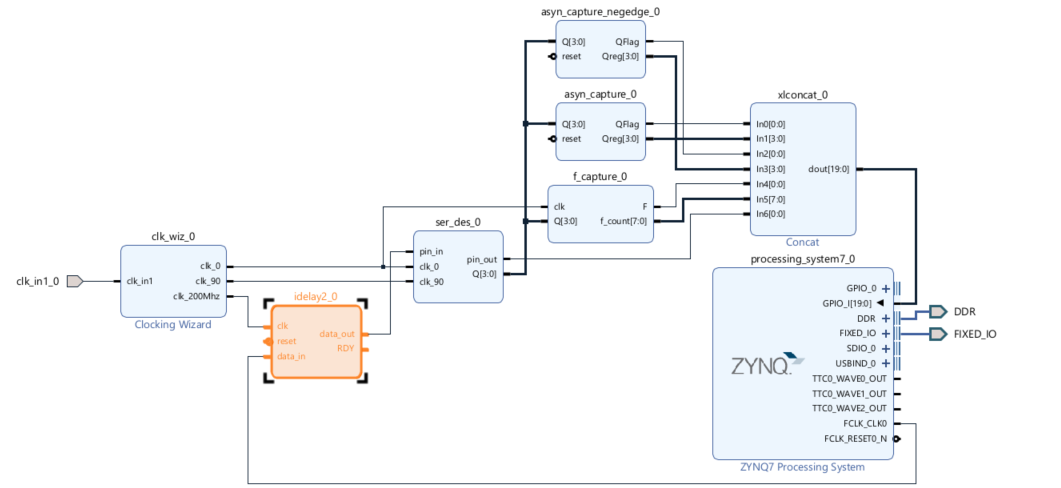

In [4]:
from IPython.display import Image
image_path = './sdup.png'
Image(filename=image_path)

## 4.0 - Data processing code

In [13]:
from pynq import Overlay

ol = Overlay("./design_300Mhz.bit")

In [14]:
from pynq import GPIO

pin_0 = GPIO(GPIO.get_gpio_pin(0), 'in')   # QFlag_pos
pin_1 = GPIO(GPIO.get_gpio_pin(1), 'in')   # Asyn0
pin_2 = GPIO(GPIO.get_gpio_pin(2), 'in')   # Asyn1
pin_3 = GPIO(GPIO.get_gpio_pin(3), 'in')   # Asyn2
pin_4 = GPIO(GPIO.get_gpio_pin(4), 'in')   # Asyn3
pin_5 = GPIO(GPIO.get_gpio_pin(5), 'in')   # QFlag_neg
pin_6 = GPIO(GPIO.get_gpio_pin(6), 'in')   # Asyn_neg0
pin_7 = GPIO(GPIO.get_gpio_pin(7), 'in')   # Asyn_neg1
pin_8 = GPIO(GPIO.get_gpio_pin(8), 'in')   # Asyn_neg2
pin_9 = GPIO(GPIO.get_gpio_pin(9), 'in')   # Asyn_neg3
pin_10= GPIO(GPIO.get_gpio_pin(10), 'in')  # F_flag
pin_11= GPIO(GPIO.get_gpio_pin(11), 'in')  # Count0
pin_12= GPIO(GPIO.get_gpio_pin(12), 'in')  # Count1
pin_13= GPIO(GPIO.get_gpio_pin(13), 'in')  # Count2
pin_14= GPIO(GPIO.get_gpio_pin(14), 'in')  # Count3
pin_15= GPIO(GPIO.get_gpio_pin(15), 'in')  # Count4
pin_16= GPIO(GPIO.get_gpio_pin(16), 'in')  # Count5
pin_17 = GPIO(GPIO.get_gpio_pin(17), 'in') # Count6
pin_18 = GPIO(GPIO.get_gpio_pin(18), 'in') # Count7
pin_19 = GPIO(GPIO.get_gpio_pin(19), 'in') # Cer_des     


capture_posedge     = [pin_4,pin_3,pin_2,pin_1]
capture_negadge     = [pin_9,pin_8,pin_7,pin_6]
capture_f           = [pin_18,pin_17,pin_16,pin_15,pin_14,pin_13,pin_12,pin_11]


In [15]:
import time
from pynq import Clocks

##############################################################################

listClock = [0.8,1,5,10,20,25]
gold_data = [625,500,100,50.0, 25.0, 20]

result = []
diff = []
##############################################################################

for enum in listClock:
    time.sleep(1)
    Clocks.fclk0_mhz = enum
    print(f'{Clocks.fclk0_mhz}')
    
    capture_posedge_list = []
    capture_negadge_list = []
    capture_f_list       = []

    int_capture_posedge = 0
    int_capture_negadge = 0
    int_capture_f_list  = 0
    
    ##############################################################################

    ##############################################################################
    print("posedge",end='       ')
    for list in capture_posedge:
        capture_posedge_list.append(list.read())
        print(list.read(),end=' ')

    print("")

    print("negedge",end='       ')
    for list in capture_negadge:
        capture_negadge_list.append(list.read())
        print(list.read(),end=' ')

    print("")

    print("capture_f",end='     ')
    for list in capture_f:
        capture_f_list.append(list.read())
        print(list.read(),end=' ')   
    print("|",end=' ')    
    binary_string = ''.join(map(str, capture_f_list))
    decimal_number = int(binary_string, 2)
    print(decimal_number)

    ##############################################################################

    ##############################################################################
    posedge_plus_negage_vector = capture_posedge_list + capture_negadge_list

    def count_ones(vector):
        count = 0
        for element in vector:
            if element == 1:
                count += 1
        return count
    print(count_ones(posedge_plus_negage_vector))

    ##############################################################################

    ##############################################################################
    tdc_resolution = 0.83325
    clock_resolution = 3.3333 


    # The formula for calculating time
    min_time_impulse = (decimal_number * clock_resolution) + (tdc_resolution * count_ones(posedge_plus_negage_vector)) 
    print(min_time_impulse)
    #print(listClock.index(enum)) 
    result.append(min_time_impulse)
    print('________________________')

print(result)

for i in range(len(gold_data)):
    diff.append(gold_data[i] - result[i])

rounded_diff = [round(element, 4) for element in diff]
print(rounded_diff)

0.8
posedge       1 1 0 0 
negedge       0 0 0 0 
capture_f     1 0 1 1 1 0 1 1 | 187
2
624.9936
________________________
1.0
posedge       1 1 0 0 
negedge       0 0 1 1 
capture_f     1 0 0 1 0 1 0 1 | 149
4
499.9947
________________________
5.0
posedge       1 1 0 0 
negedge       0 0 1 1 
capture_f     0 0 0 1 1 1 0 1 | 29
4
99.9987
________________________
10.0
posedge       1 1 0 0 
negedge       0 0 1 1 
capture_f     0 0 0 0 1 1 1 0 | 14
4
49.999199999999995
________________________
20.0
posedge       1 1 0 0 
negedge       0 0 0 0 
capture_f     0 0 0 0 0 1 1 1 | 7
2
24.999599999999997
________________________
25.0
posedge       1 1 0 0 
negedge       0 0 1 1 
capture_f     0 0 0 0 0 1 0 1 | 5
4
19.999499999999998
________________________
[624.9936, 499.9947, 99.9987, 49.999199999999995, 24.999599999999997, 19.999499999999998]
[0.0064, 0.0053, 0.0013, 0.0008, 0.0004, 0.0005]


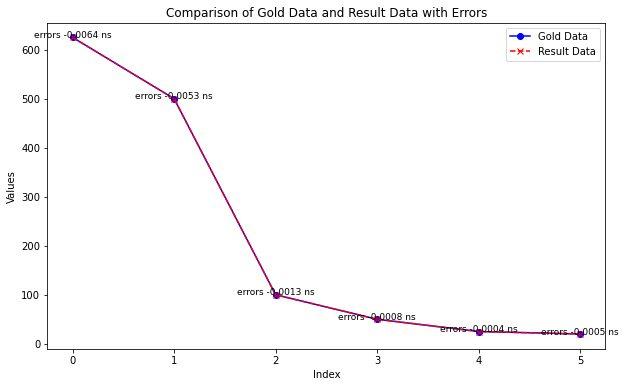

In [17]:
import numpy as np
import matplotlib.pyplot as plt



# Рассчитаем ошибки
errors = result - gold_data

# Построение графика сравнения
plt.figure(figsize=(10, 6))

# График значений gold_data и result
plt.plot(gold_data, label="Gold Data", marker='o', linestyle='-', color='b')
plt.plot(result, label="Result Data", marker='x', linestyle='--', color='r')

# Отображение ошибок над точками
for i in range(len(gold_data)):
    plt.text(i, result[i], f'errors {errors[i]:.4f} ns', fontsize=9, color='black', ha='center')


# Оформление графика
plt.title("Comparison of Gold Data and Result Data with Errors")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()

# Отображение графика
plt.show()

In [19]:
import numpy as np

# Data in the form of numpy arrays
gold_data = np.array(gold_data)
result = np.array(result)
rounded_diff = np.array(rounded_diff)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(result - gold_data))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((result - gold_data) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.6f}")

# Mean Error
mean_diff = np.mean(result - gold_data)
print(f"Mean Error: {mean_diff:.6f}")

# Range of Errors
range_diff = np.max(result - gold_data) - np.min(result - gold_data)
print(f"Range of Errors: {range_diff:.6f}")

# Rounded Differences
print("Rounded Differences:")
print(rounded_diff)


Mean Absolute Error (MAE): 0.002450
Root Mean Square Error (RMSE): 0.003459
Mean Error: -0.002450
Range of Errors: 0.006000
Rounded Differences:
[0.0064 0.0053 0.0013 0.0008 0.0004 0.0005]


## 5.0 Measurement Results
From the provided data, it is clear that the measurement accuracy meets the designed expectations.

## 6.0 Vivado

To fully open the project in Vivado with the already assembled 'block_design', you can use the design_300Mhz.tcl file, which is also located in the repository.